<a href="https://colab.research.google.com/github/AIRJK/CPA-Attack/blob/master/DL_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

数据预处理

In [ ]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import numpy as np
from torch.nn import init

trace = np.load('drive/My Drive/DeepLearning/RAWDATE/DPAv4_dataset/attack_traces_dpav4.npy')
label = np.load('drive/My Drive/DeepLearning/RAWDATE/DPAv4_dataset/attack_labels_dpav4.npy')
print(label)
print(label.shape)

In [ ]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import numpy as np
from torch.nn import init

trace = np.load('drive/My Drive/DeepLearning/RAWDATE/DPAv4_dataset/profiling_traces_dpav4.npy')
label = np.load('drive/My Drive/DeepLearning/RAWDATE/DPAv4_dataset/profiling_labels_dpav4.npy')
print(label)
print(label.shape)
trace1 = np.empty((50,4000),dtype = np.float32)
label1 = np.empty(50, dtype = np.int)
for i in range(50):
  trace1[i] = trace[i]
  label1[i] = label[i]

np.savetxt('drive/My Drive/DeepLearning/RAWDATE/DPAv4_dataset/trace1.txt', trace1, fmt = '%f')
np.savetxt('drive/My Drive/DeepLearning/RAWDATE/DPAv4_dataset/label1.txt', label1, fmt = '%d')
  

print(label)
print(label1)

训练模型

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import numpy as np
from torch.nn import init

 
INPUT_SIZE = 4000  #输入维数
HIDDEN_SIZE = 100  #第一层神经元个数
NUM_CLASS = 256  #输出维数  256或9
NUM_EPOCH = 50  
BATCH_SIZE = 50  
BYTE = 0
USE_CUDA = torch.cuda.is_available()
np.random.seed(1)
torch.manual_seed(1)
if USE_CUDA:
    torch.cuda.manual_seed(1)



m = np.loadtxt('drive/My Drive/DeepLearning/RAWDATE/DPAv4_dataset/label2.txt', dtype = np.int)
power = np.loadtxt('drive/My Drive/DeepLearning/RAWDATE/DPAv4_dataset/trace2.txt', dtype = np.float32)


t_m = m[:4000]
t_p = power[:4000, :]
v_m = m[4000:]
v_p = power[4000:, :]
v_p = torch.Tensor(v_p)

class TrainData(data.Dataset):
  def __init__(self, m, power):
    super(TrainData, self).__init__()  #
    self.m = torch.LongTensor(m) #取出标签（训练集50个，取出后为50×1的tensor）
    self.power = torch.Tensor(power) #取出波形（训练集50个，取出后为50×4000的tensor）

  def __len__(self):
    return len(self.m)

  def __getitem__(self, index):
    
    trace = self.power[index] 
    trace = trace.unsqueeze(0) #取出具体的第index条波的波形
    label = self.m[index]    #取出具体的第index条波的标签
    return trace, label


dataset = TrainData(m, power)
dataloader = data.DataLoader(dataset, batch_size = BATCH_SIZE , shuffle = True, num_workers = 5)  #batch_size = 50

In [2]:

    
    

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(in_channels = 1, out_channels = 2, kernel_size = 1)
        nn.init.kaiming_normal(self.conv1.weight)      
        init.constant(self.conv1.bias, 0.1)
        self.bn = nn.BatchNorm1d(2)
        self.fc1 = nn.Linear(4000, 2)  #全连接层  4000->2
        self.fc2 = nn.Linear(2, 256)  #全连接层   2->256或9
        

    def forward(self, x):
        x = F.selu(self.conv1(x))#4000
        # out = self.bn()
        x = F.avg_pool1d(x, 2, 2)  #1562或1563
        x = x.view(x.size(0),-1)
        x = F.selu(self.fc1(x))
        x = self.fc2(x)
        
        return x


class Net2(nn.Module):
  def __init__(self):
    super(Net2, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Conv1d(1,2,1),
          nn.BatchNorm1d(2),
          nn.SELU(),
          nn.AvgPool1d(2)
    )
    self.fc1 = nn.Linear(4000, 2)
    self.fc2 = nn.Linear(2, 256)
  
  def forward(self, x):
    out = self.layer1(x)
    out = out.view(out.size(0),-1)
    out = F.selu(self.fc1(out))
    out = self.fc2(out)
    return out        








    

In [3]:

net = Net2() 
print(net)
# print(dataset.hd[0])
# print(dataset.power[0])
if USE_CUDA:
  net = net.cuda()

lr = 0.001
NUM_EPOCH = 150

optimizer = torch.optim.Adam(net.parameters(), lr=lr)
loss_func = nn.CrossEntropyLoss()

accuracy = []
crossentropy = []


for epoch in range(NUM_EPOCH):
  for i,(t,h) in enumerate(dataloader):
    if USE_CUDA:
      t = t.cuda()
      h = h.cuda()
    
    h_pred = net(t)
    
    loss = loss_func(h_pred, h)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i%100 == 0:
      print('Epoch:',epoch, loss.item())
  if USE_CUDA:
      v_p = v_p.cuda()
  with torch.no_grad():
    p_m = net(v_p.unsqueeze(1))
  predictions =  zip(range(0, 500),p_m.max(1)[1].cpu().data.tolist())
  sum = 0
  tmp = np.empty(500,dtype = np.int)
  for i,x in predictions:
    tmp[i] = x
    if x == v_m[i].item():
      sum += 1


  accuracy.append(sum/500)
  crossentropy.append(loss)
  torch.save(net.state_dict(), 'drive/My Drive/DeepLearning/RAWDATE/DPAv4_dataset/net_params.pkl')
  if epoch == NUM_EPOCH-1:
    print(tmp)
    np.savetxt('drive/My Drive/DeepLearning/RAWDATE/DPAv4_dataset/prediction.txt', tmp, fmt = '%d')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  # This is added back by InteractiveShellApp.init_path()


Net(
  (conv1): Conv1d(1, 2, kernel_size=(1,), stride=(1,))
  (bn): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=4000, out_features=2, bias=True)
  (fc2): Linear(in_features=2, out_features=256, bias=True)
)
Epoch: 0 5.527017593383789
Epoch: 1 5.574195384979248
Epoch: 2 5.633457183837891
Epoch: 3 5.653864860534668
Epoch: 4 5.643199443817139
Epoch: 5 5.5006608963012695
Epoch: 6 5.581912994384766
Epoch: 7 5.54478645324707
Epoch: 8 5.575887680053711
Epoch: 9 5.581758975982666
Epoch: 10 5.540246486663818
Epoch: 11 5.672314643859863
Epoch: 12 5.5288405418396
Epoch: 13 5.535464286804199
Epoch: 14 5.513554573059082
Epoch: 15 5.479854583740234
Epoch: 16 5.480495452880859
Epoch: 17 5.539882659912109
Epoch: 18 5.530088424682617
Epoch: 19 5.523623466491699
Epoch: 20 5.521883487701416
Epoch: 21 5.507598400115967
Epoch: 22 5.4865288734436035
Epoch: 23 5.420867919921875
Epoch: 24 5.550338268280029
Epoch: 25 5.524890899658203
Epoch: 26 5.4

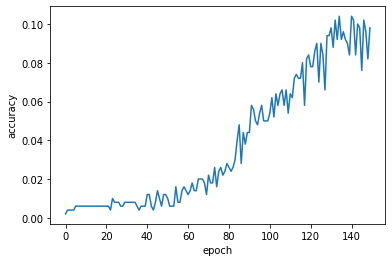

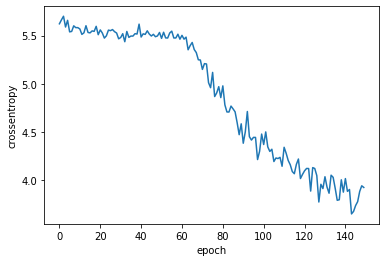

In [4]:
from matplotlib import pyplot as plt

plt.plot(range(150),accuracy)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

plt.plot(range(150),crossentropy)
plt.xlabel("epoch")
plt.ylabel("crossentropy")
plt.show()